**SECTION 1 -**
**Imports**

Importing all required libraries



In [1]:
!pip install yfinance pandas_ta xgboost matplotlib pandas numpy


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_ta as ta
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

**CONFIGURATION -**

This block defines all strategy parameters in one place.
You should tweak only this cell when experimenting with risk, universe, or exits.

In [3]:
# Trading Universe
STOCKS = ["RELIANCE.NS", "TCS.NS", "SBIN.NS", "HDFCBANK.NS", "ITC.NS"]
INDEX = "^NSEI"

# Data Range
START_DATE = "2013-01-01"
END_DATE = "2025-12-31"

# Capital & Risk
INITIAL_CAPITAL = 1_000_000      # Starting capital (₹10L)
RISK_PER_TRADE = 0.005           # 0.5% risk per trade
MAX_POSITIONS = 3                # Max simultaneous positions

# Trade Management
ATR_MULT = 1.1                   # Stop-loss = 1.1 × ATR
PROFIT_TARGET = 0.02             # 2% take profit
MAX_HOLD_DAYS = 4                # Time-based exit

# ML Features
FEATURES = ["RSI", "Z", "ADX", "ATR"]

**Download Stock & Index Data -**

Downloads OHLC data for all stocks and NIFTY index using Yahoo Finance.
Also flattens columns to avoid MultiIndex issues.

In [4]:
stock_data = {}
for s in STOCKS:
    df = yf.download(s, start=START_DATE, end=END_DATE,
                     auto_adjust=True, progress=False)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    stock_data[s] = df[["Open", "High", "Low", "Close"]].dropna()

nifty = yf.download(INDEX, start=START_DATE, end=END_DATE,
                    auto_adjust=True, progress=False)
if isinstance(nifty.columns, pd.MultiIndex):
    nifty.columns = nifty.columns.get_level_values(0)
nifty = nifty[["Close"]].dropna()

**Feature Engineering -**

Creates all technical indicators used by the strategy and ML models.
Also creates the training target (future 3-day return).

In [5]:
processed = {}
for s, df in stock_data.items():
    t = df.copy()
    t["RSI"] = ta.rsi(t["Close"], 14)
    t["ATR"] = ta.atr(t["High"], t["Low"], t["Close"], 14)
    t["MA20"] = t["Close"].rolling(20).mean()
    t["STD20"] = t["Close"].rolling(20).std()
    t["Z"] = (t["Close"] - t["MA20"]) / t["STD20"]
    adx = ta.adx(t["High"], t["Low"], t["Close"], 14)
    t["ADX"] = adx.iloc[:, 0]
    t["Target"] = (t["Close"].shift(-3) > t["Close"] * 1.005).astype(int)
    processed[s] = t.dropna()

**Train ML Models (2014–2024) -**

Trains two ML models per stock:



*   XGBoost (non-linear patterns)
*   Random Forest (stable regime patterns)







These are later combined as an ensemble.

In [6]:
models = {}
for s in STOCKS:
    train = processed[s].loc["2014-01-01":"2024-12-31"]
    X, y = train[FEATURES], train["Target"]

    xgb_model = xgb.XGBClassifier(
        n_estimators=150, max_depth=3, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        verbosity=0, random_state=42
    )
    rf_model = RandomForestClassifier(
        n_estimators=300, max_depth=6,
        min_samples_leaf=20, random_state=42
    )

    xgb_model.fit(X, y)
    rf_model.fit(X, y)
    models[s] = (xgb_model, rf_model)

**Trading Simulation (2025) -**

Runs the full long-short strategy on unseen 2025 data.

Includes:



*   Ensemble ML filtering
*   Stop-loss, take-profit, time exit
*   Trade logging



In [7]:
cash = INITIAL_CAPITAL
portfolio = {}
equity = []
trade_log = []

nifty_2025 = nifty.loc["2025-01-01":"2025-12-31"]

for date in nifty_2025.index:

    total = cash
    for s, pos in portfolio.items():
        total += pos["qty"] * stock_data[s].loc[date, "Close"] * pos["dir"]
    equity.append(total)

    for s in STOCKS:
        if date not in processed[s].index:
            continue

        row = processed[s].loc[date]
        price = stock_data[s].loc[date, "Close"]

        # EXIT
        if s in portfolio:
            pos = portfolio[s]
            pos["days"] += 1

            exit_cond = (
                (pos["dir"] == 1 and (price <= pos["sl"] or price >= pos["tp"])) or
                (pos["dir"] == -1 and (price >= pos["sl"] or price <= pos["tp"])) or
                pos["days"] >= MAX_HOLD_DAYS
            )

            if exit_cond:
                pnl = pos["qty"] * (price - pos["entry"]) * pos["dir"]
                cash += pos["qty"] * price * pos["dir"]

                trade_log.append({
                    "Stock": s,
                    "Direction": "LONG" if pos["dir"] == 1 else "SHORT",
                    "EntryPrice": pos["entry"],
                    "ExitPrice": price,
                    "Qty": pos["qty"],
                    "PnL": pnl,
                    "ExitDate": date
                })

                del portfolio[s]
            continue

        if len(portfolio) >= MAX_POSITIONS:
            continue

        xgb_m, rf_m = models[s]
        prob = (
            xgb_m.predict_proba(pd.DataFrame([row[FEATURES]]))[0][1] +
            rf_m.predict_proba(pd.DataFrame([row[FEATURES]]))[0][1]
        ) / 2

        risk_amt = cash * RISK_PER_TRADE

        # LONG
        if row["Z"] < -1.5 and prob > 0.60:
            sl = price - ATR_MULT * row["ATR"]
            qty = int(risk_amt / (price - sl))
            if qty > 0:
                cash -= qty * price
                portfolio[s] = {
                    "qty": qty,
                    "sl": sl,
                    "tp": price * (1 + PROFIT_TARGET),
                    "dir": 1,
                    "days": 0,
                    "entry": price
                }

        # SHORT
        elif row["Z"] > 1.5 and prob < 0.40:
            sl = price + ATR_MULT * row["ATR"]
            qty = int(risk_amt / (sl - price))
            if qty > 0:
                cash += qty * price
                portfolio[s] = {
                    "qty": qty,
                    "sl": sl,
                    "tp": price * (1 - PROFIT_TARGET),
                    "dir": -1,
                    "days": 0,
                    "entry": price
                }


**Overall Portfolio Performance -**

Calculates portfolio equity curve, returns, Sharpe ratio, and prints final results.



*   Initial Capital = 1,000,000



In [9]:
equity_series = pd.Series(equity, index=nifty_2025.index)
returns = equity_series.pct_change().dropna()

sharpe = np.sqrt(252) * returns.mean() / returns.std()
ret = (equity_series.iloc[-1] / INITIAL_CAPITAL - 1) * 100

print("=" * 55)
print(" RESULTS")
print("=" * 55)
print(f"Final Capital : ₹{equity_series.iloc[-1]:,.0f}")
print(f"Total Return  : {ret:.2f}%")
print(f"Sharpe Ratio  : {sharpe:.2f}")
print("=" * 55)

 RESULTS
Final Capital : ₹1,035,483
Total Return  : 3.55%
Sharpe Ratio  : 0.72


**Stock-Wise Performance Tables -**

It Shows :

*   How much each stock made/lost
*   Number of trades
*   Capital deployed per stock



In [10]:
trades_df = pd.DataFrame(trade_log)

summary = (
    trades_df
    .groupby("Stock")
    .agg(
        Trades=("PnL", "count"),
        Net_PnL=("PnL", "sum"),
        Avg_PnL=("PnL", "mean"),
        Avg_Position_Value=("EntryPrice", lambda x: np.mean(x))
    )
    .reset_index()
)

summary["Return_%"] = (summary["Net_PnL"] / INITIAL_CAPITAL) * 100
print("\nSTOCK-WISE PERFORMANCE")
print(summary.round(2))

capital_used = (
    trades_df
    .assign(PositionValue=lambda x: x["EntryPrice"] * x["Qty"])
    .groupby("Stock")["PositionValue"]
    .mean()
    .reset_index(name="Avg Capital Used")
)

print("\nCAPITAL UTILIZATION")
print(capital_used.round(0))


STOCK-WISE PERFORMANCE
         Stock  Trades   Net_PnL  Avg_PnL  Avg_Position_Value  Return_%
0  HDFCBANK.NS       9  20340.54  2260.06              959.20      2.03
1       ITC.NS      13  21871.63  1682.43              418.11      2.19
2  RELIANCE.NS       8    211.85    26.48             1434.14      0.02
3      SBIN.NS       7 -25107.75 -3586.82              860.29     -2.51
4       TCS.NS       9  18166.97  2018.55             3294.56      1.82

CAPITAL UTILIZATION
         Stock  Avg Capital Used
0  HDFCBANK.NS          345740.0
1       ITC.NS          347217.0
2  RELIANCE.NS          346651.0
3      SBIN.NS          423288.0
4       TCS.NS          295260.0


**Visualization -**

Plots :


*   Overall portfolio equity
*   Stock-wise cumulative PnL
* Capital deployed per stock



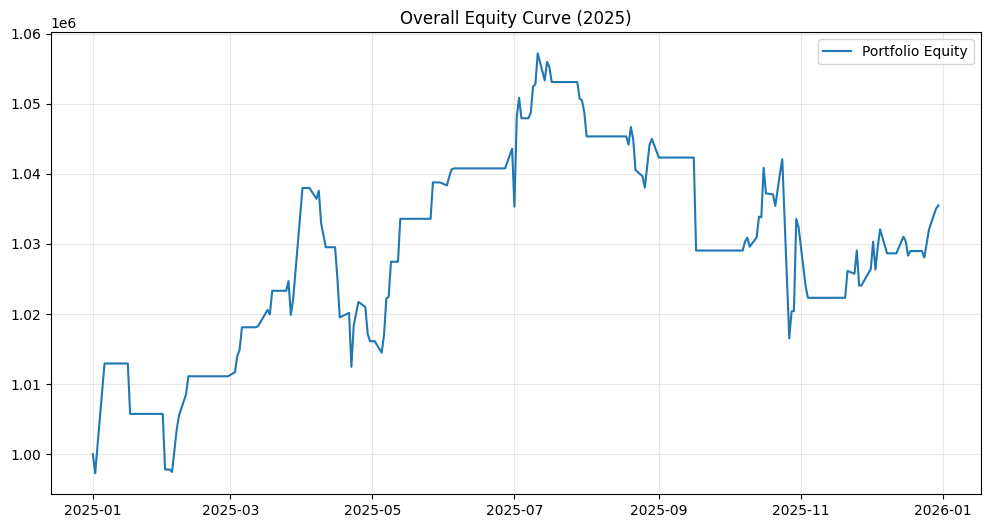

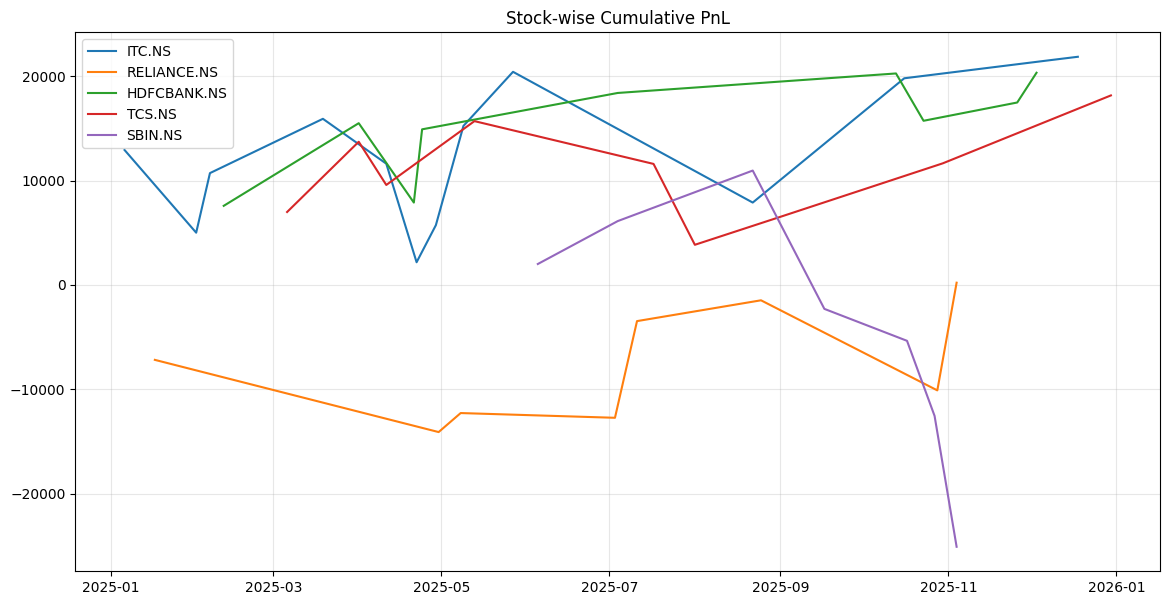

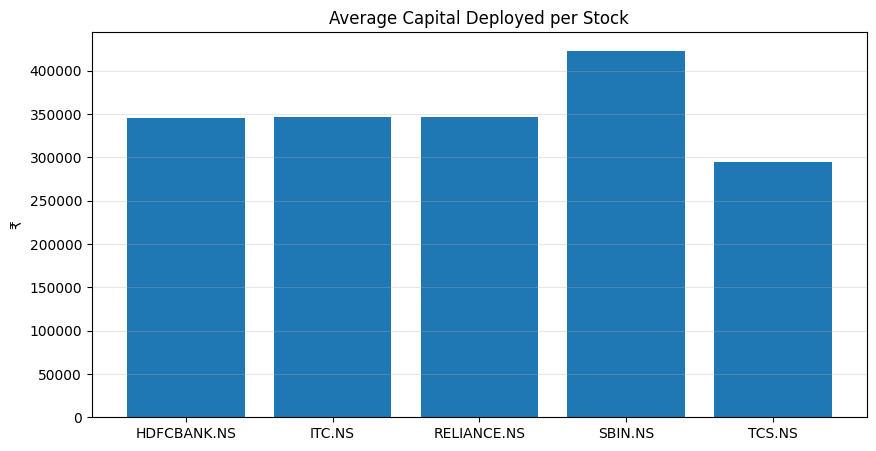

In [11]:
plt.figure(figsize=(12,6))
plt.plot(equity_series, label="Portfolio Equity")
plt.title("Overall Equity Curve (2025)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

plt.figure(figsize=(14,7))
for s in trades_df["Stock"].unique():
    d = trades_df[trades_df["Stock"] == s].sort_values("ExitDate")
    plt.plot(d["ExitDate"], d["PnL"].cumsum(), label=s)
plt.title("Stock-wise Cumulative PnL")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.bar(capital_used["Stock"], capital_used["Avg Capital Used"])
plt.title("Average Capital Deployed per Stock")
plt.ylabel("₹")
plt.grid(axis="y", alpha=0.3)
plt.show()
